# Imports and data file

In [1]:
# linear algebra and Data Processing
import numpy as np 
import pandas as pd 
import itertools

# Data Visualization
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

# Time Series Functions
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Algorithms
from statsmodels.tsa.stattools import adfuller

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Remove Warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# data files
train_df = pd.read_csv('data.csv')


## Metadata

* ID - Transaction ID
* Date - Transaction Date
* Item # - Item #
* Description - Product Description
* Category - Product Category
* Qty - Quantity Sold
* Retail - Sell Price
* Subtotal - Order Subtotal
* Discount - Discount Amount

## First Glance

In [3]:
train_df.head()

,ID,Date,Item #,Description,Category,Qty,Cost,Retail,Subtotal,Discount,With Discount,Profit,Margin
0,6847,2020-09-16,210000002056,ESI GRIPS EXTRA CHUNKY BLACK,Product,2,$16.89,$35.00,$70.00,$0.00,$70.00,$36.21,51.73%
1,6847,2020-09-16,210000002004,"Chamois Butt'R, Her, Box of 10, 9ml packet",Product,2,$1.00,$2.50,$5.00,$0.00,$5.00,$3.00,60.00%
2,7455,2020-08-04,210000002769,49N STD 700C x 28-35MM S/V40,Product,1,$3.60,$7.00,$7.00,$0.00,$7.00,$3.40,48.61%
3,7455,2020-08-04,210000000000,26 X 1.50-1.75 (35) TUBE ~,Labour,1,$0.00,$7.00,$7.00,$0.00,$7.00,$7.00,100.00%
4,7455,2020-08-04,210000002666,PRIME SLD MAT BLU L/XL,Product,1,$42.50,$85.00,$85.00,$0.00,$85.00,$42.50,50.00%


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22403 entries, 0 to 22402
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             22403 non-null  int64 
 1   Date           22403 non-null  object
 2   Item #         22403 non-null  int64 
 3   Description    22403 non-null  object
 4   Category       22403 non-null  object
 5   Qty            22403 non-null  int64 
 6   Cost           22403 non-null  object
 7   Retail         22403 non-null  object
 8   Subtotal       22403 non-null  object
 9   Discount       22403 non-null  object
 10  With Discount  22403 non-null  object
 11  Profit         22403 non-null  object
 12  Margin         22403 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.2+ MB


## Data Preprocessing and EDAs

In [5]:
# Convert Date to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])

# Remove $ from 'Discount' columns
train_df['Discount'] = train_df['Discount'].str.replace('$', '')

# Convert 'Discount' columns to numeric
train_df['Discount'] = pd.to_numeric(train_df['Discount'], errors='coerce')

# Drop columns
train_df = train_df.drop(columns=['ID', 'Description', 'Cost', 'Retail', 'Subtotal', 'With Discount', 'Profit', 'Margin'], axis=1)


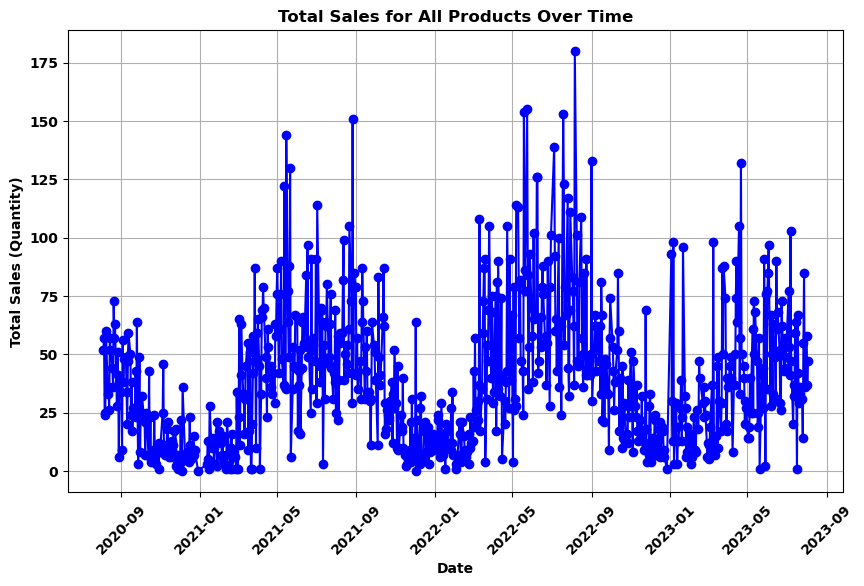

In [6]:
# Group the data by date and calculate the total sales (quantity) per date
total_sales_per_date = train_df.groupby("Date")["Qty"].sum()

# Plot total sales over time
plt.figure(figsize=(10, 6))
plt.plot(total_sales_per_date.index, total_sales_per_date.values, marker='o', linestyle='-', color='b')
plt.xlabel("Date")
plt.ylabel("Total Sales (Quantity)")
plt.title("Total Sales for All Products Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

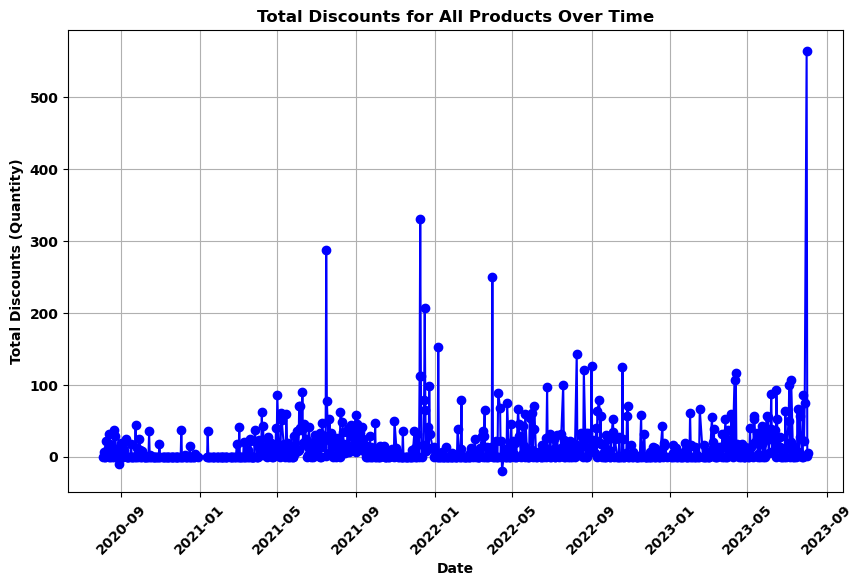

In [7]:
# Group the data by date and calculate the total disount (quantity) per date
total_discounts_per_date = train_df.groupby("Date")["Discount"].sum()

# Plot total discounts over time
plt.figure(figsize=(10, 6))
plt.plot(total_discounts_per_date.index, total_discounts_per_date.values, marker='o', linestyle='-', color='b')
plt.xlabel("Date")
plt.ylabel("Total Discounts (Quantity)")
plt.title("Total Discounts for All Products Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Decomposition and Visualization

In [8]:
# Set 'Date' as the index
train_df.set_index('Date', inplace=True)

# Change the frequency to dtaily ('D')
frequency = 'D'

# Resample the data to daily frequency
daily_subtotal = train_df['Qty'].resample(frequency).sum()

# Decompose the time series
decomposition = seasonal_decompose(daily_subtotal, model='additive')

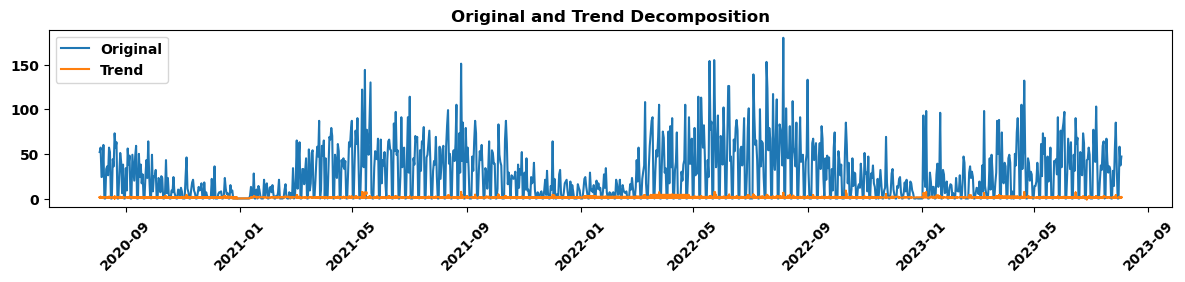

Trend:
Mean: 1.3263197266758966
Standard Deviation: 0.5984699944730547



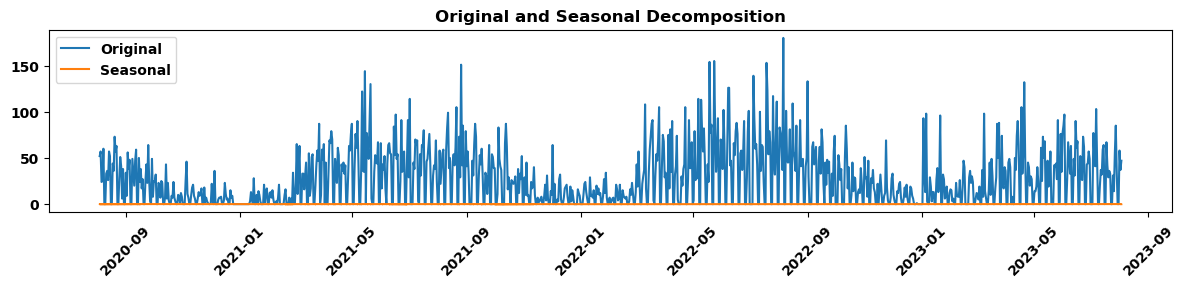

Seasonal:
Mean: -4.787829908830537e-07
Standard Deviation: 0.028534468066183184



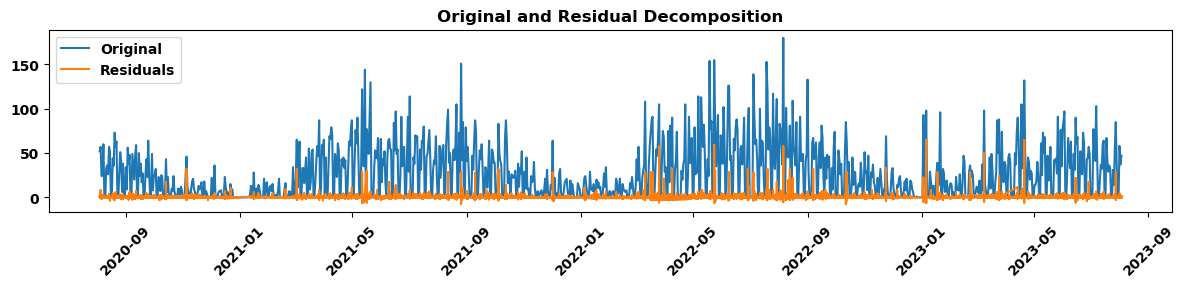

Residuals:
Mean: 1.4267670599807239e-05
Standard Deviation: 1.8126694344409096


In [9]:
# Calculate trend, seasonal, and residuals
def calculate_components(data):
    decomposition = seasonal_decompose(data, model='additive', period=12)
    trend = decomposition.trend
    mean_trend = np.mean(trend)
    std_trend = np.std(trend)
    
    seasonal = decomposition.seasonal
    mean_seasonal = np.mean(seasonal)
    std_seasonal = np.std(seasonal)
    
    residuals = decomposition.resid
    mean_residuals = np.mean(residuals)
    std_residuals = np.std(residuals)
    
    return trend, mean_trend, std_trend, seasonal, mean_seasonal, std_seasonal, residuals, mean_residuals, std_residuals

# Calculate components
trend, mean_trend, std_trend, seasonal, mean_seasonal, std_seasonal, residuals, mean_residuals, std_residuals = calculate_components(train_df['Qty'])

# Plot the decomposition
plt.figure(figsize=(12, 10))

# Plot the original and trend component
plt.subplot(4, 1, 1)
plt.plot(daily_subtotal, label='Original')
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.title('Original and Trend Decomposition')
plt.tight_layout()
plt.show()

print('Trend:')
print('Mean:', mean_trend)
print('Standard Deviation:', std_trend)
print()

# Plot the original and seasonal component
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 2)
plt.plot(daily_subtotal, label='Original')
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.title('Original and Seasonal Decomposition')
plt.tight_layout()
plt.show()

print('Seasonal:')
print('Mean:', mean_seasonal)
print('Standard Deviation:', std_seasonal)
print()

# Plot the original and residual component
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 3)
plt.plot(daily_subtotal, label='Original')
plt.plot(residuals, label='Residuals')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.title('Original and Residual Decomposition')
plt.tight_layout()
plt.show()

print('Residuals:')
print('Mean:', mean_residuals)
print('Standard Deviation:', std_residuals)

## Stationarity Check - Qty

In [10]:
# Perform ADF test for stationarity
def perform_adf_test(data, title):
    # Drop missing values before performing the test
    data = data.dropna()
    
    result = adfuller(data)
    print(f'ADF Test for {title}:')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    print('Is Stationary:', result[1] <= 0.05)
    print()

# Perform ADF test for each component
perform_adf_test(trend, 'Trend')
perform_adf_test(seasonal, 'Seasonal')
perform_adf_test(residuals, 'Residuals')

ADF Test for Trend:
ADF Statistic: -17.320309899969427
p-value: 5.4865680675619716e-30
Critical Values: {'1%': -3.4306427114284506, '5%': -2.861669368911081, '10%': -2.5668388594066016}
Is Stationary: True

ADF Test for Seasonal:
ADF Statistic: -1164123319146050.8
p-value: 0.0
Critical Values: {'1%': -3.430642436538191, '5%': -2.8616692474245298, '10%': -2.566838794741712}
Is Stationary: True

ADF Test for Residuals:
ADF Statistic: -45.38242177046898
p-value: 0.0
Critical Values: {'1%': -3.4306427114284506, '5%': -2.861669368911081, '10%': -2.5668388594066016}
Is Stationary: True



## Feature Engineering

In [11]:
# Drop rows with 'Labour', 'Quote', and 'Special Order' in the 'Category' column, we only need stocked product
train_df = train_df[~train_df['Category'].isin(['Labour', 'Quote', 'Special Order'])]

# Drop 'Category' column, all rows are now stock products
train_df = train_df.drop(columns=['Category'], axis=1)


## SARIMA Model

In [12]:
# Define the target variable
y = train_df['Qty']

# Define the number of training samples
n_train = len(y) - 7
n_test = 7

# Split the data into training and test sets
train = y[:n_train]
test = y[-n_test:]


In [ ]:
# Function to find the best SARIMA parameters
def find_best_sarima_params(data, p_range, d_range, q_range, s_range):
    best_aic = np.inf
    best_params = None
    for p in p_range:
        for d in d_range:
            for q in q_range:
                for s in s_range:
                    try:
                        model = SARIMAX(data, order=(p, d, q), seasonal_order=(s, 1, 1, 12))
                        results = model.fit(disp=False)
                        if results.aic < best_aic:
                            best_aic = results.aic
                            best_params = (p, d, q, s)
                    except:
                        continue
    return best_params

# Define the ranges for SARIMA parameters
p_range = range(0, 3)
d_range = range(0, 2)
q_range = range(0, 3)
s_range = range(0, 2)

# Find the best SARIMA parameters
best_params = find_best_sarima_params(train, p_range, d_range, q_range, s_range)
print("Best SARIMA Parameters:", best_params)


## Fit Model

In [ ]:
# Create and fit the SARIMA model using the best parameters
model = SARIMAX(train, order=best_params[:3], seasonal_order=(best_params[3], 1, 1, 12))
results = model.fit(disp=False)

# Forecast data for the same number of steps as the length of the test dataset
forecast_steps = len(test)
forecast = results.get_forecast(steps=forecast_steps).predicted_mean


## Model Evaluation

In [ ]:
print('Model Evaluation:')
print('-----------------')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test, forecast)
print("Mean Absolute Error:", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test, forecast)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)


## Plot Forecast

In [ ]:
# Create a dataframe of future dates for forecasting
forecast_period = 365  # Forecast for 30 days ahead
future = pd.date_range(start=test.index.max(), periods=forecast_period, freq='D')

# Make forecasts for the future dates
forecast = results.get_forecast(steps=forecast_period).predicted_mean

# Plot the training, test, and forecast data
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data')
plt.plot(future, forecast, label='Forecast', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Training, Test, and Forecast Data')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
